# Previsão de Renda Anual

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle 
import shap
import time, datetime

from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection, metrics

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import scipy.stats as st
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Funções
def countplot(x):
    print(data[x].value_counts(normalize = True).round(2))
    plt.figure(figsize=(10,7))
    sns.countplot(data = data, y = x, order = data[x].value_counts().index, palette = 'BrBG_r')
    plt.title(x)
    plt.show()

def quantitativas(x):
    print(data[x].describe())
    fig, axs = plt.subplots(ncols = 2, figsize=(18,8))
    sns.distplot(data[x], kde = False, norm_hist=True, ax = axs[0])
    sns.boxplot(data = data, y = x, ax = axs[1])

def relacao_target(x):
    print(pd.crosstab(data[x], data['over50k'], normalize = 'index').reset_index().sort_values('>50K', ascending = False))
    plt.figure(figsize = (13, 8))
    sns.countplot(data = data, x = x, hue = 'over50k', order = data[x].value_counts().index, palette = 'BrBG_r')

def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
    
def print_ecdf(x):
    plt.figure(figsize = (10, 8))
    rand_normal1 = data[x]
    x,y = ecdf(rand_normal1)  
    plt.scatter(x = x, y = y)
    plt.ylabel('Distribuição da Base', fontsize = 12)

###############################################

def treina_testa_modelo(metrica):
    # Testa a performance do modelo base
    # Preparando a lista de modelos
    modelos = []
    modelos.append(('LogisticRegression', LogisticRegression()))
    modelos.append(('KNeighborsClassifier', KNeighborsClassifier()))
    modelos.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    modelos.append(('RandomForestClassifier', RandomForestClassifier()))
    modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

    # Avaliando cada modelo em um loop
    resultados = []
    nomes = []

    for nome, modelo in modelos:
        kfold = KFold(n_splits = 10, random_state = 1)
        cv_results = cross_val_score(modelo, x, y, cv = kfold, scoring = metrica)
        resultados.append(cv_results)
        nomes.append(nome)
        msg = '%s: %f (%f)' % (nome, cv_results.mean(), cv_results.std())
        print(msg)

## Importação do dataset

In [3]:
data = pd.read_csv('census_v11.csv', delimiter = ';')
data.sample(5)

,age,workclass,education,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,over50k
28551,23,?,7th-8th,Never-married,?,Not-in-family,White,Female,0,0,40,Mexico,<=50K
6853,36,Private,10th,Divorced,Other-service,Not-in-family,White,Female,0,0,40,United-States,<=50K
30107,72,Private,Some-college,Widowed,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States,<=50K
23206,72,Self-emp-not-inc,Some-college,Married-civ-spouse,Farming-fishing,_husband_,White,Male,0,0,74,United-States,<=50K
5350,34,Private,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K


Variáveis:
- age: Idade;
- workclass: Categoria da empresa em que trabalha;
- education: Grau de educação;
- maritalstatus: Estado civil;
- occupation: Área de atuação;
- relationship: Status na família;
- race: Raça;
- sex: Sexo;
- capitalgain: Ganho de capital no ano;
- capitalloss: Perda de capital no ano;
- hoursperweek: Horas trabalhadas por semana;
- nativecountry: País de origem;
- over50k: Salário anual (target)

## Resumo do dataset

In [4]:
# Tamanho do dataset
data.shape

(31978, 13)

In [5]:
# Verifica tipos de variáveis
data.dtypes

age               int64
workclass        object
education        object
maritalstatus    object
occupation       object
relationship     object
race             object
sex              object
capitalgain       int64
capitalloss       int64
hoursperweek      int64
nativecountry    object
over50k          object
dtype: object

In [6]:
# Verifica linhas vazias
data.isnull().sum()

age              0
workclass        0
education        0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
nativecountry    0
over50k          0
dtype: int64

In [7]:
# Dropa espaços em branco, uma vez que todas variáveis categóricas são separadas por '-'
data['over50k'] = data['over50k'].str.lstrip()
data['workclass'] = data['workclass'].str.lstrip()
data['education'] = data['education'].str.lstrip()
data['maritalstatus'] = data['maritalstatus'].str.lstrip()
data['occupation'] = data['occupation'].str.lstrip()
data['relationship'] = data['relationship'].str.lstrip()
data['race'] = data['race'].str.lstrip()
data['sex'] = data['sex'].str.lstrip()
data['nativecountry'] = data['nativecountry'].str.lstrip()
data['over50k'] = data['over50k'].str.lstrip()

# Análise Exploratória e Tratamento de Variáveis

## Variáveis Categóricas

Private             0.74
Self-emp-not-inc    0.08
Local-gov           0.07
State-gov           0.04
Self-emp-inc        0.04
Federal-gov         0.03
Without-pay         0.00
Never-worked        0.00
Name: workclass, dtype: float64


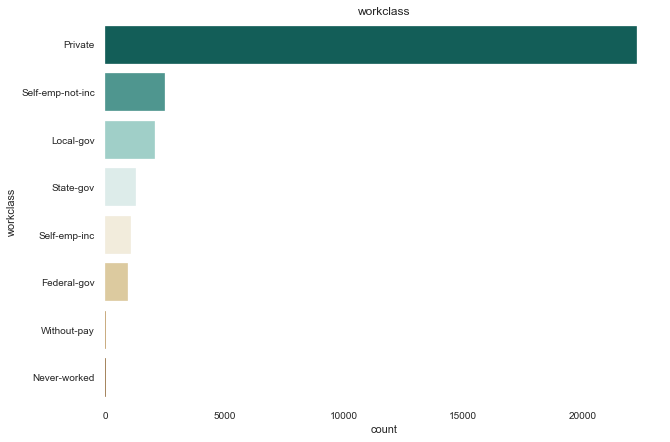

In [8]:
# Workclass
data = data[data['workclass'] != '?']
countplot('workclass')

HS-grad         0.33
Some-college    0.22
Bachelors       0.17
Masters         0.05
Assoc-voc       0.04
11th            0.03
Assoc-acdm      0.03
10th            0.03
7th-8th         0.02
Prof-school     0.02
9th             0.02
12th            0.01
Doctorate       0.01
5th-6th         0.01
1st-4th         0.01
Preschool       0.00
Name: education, dtype: float64


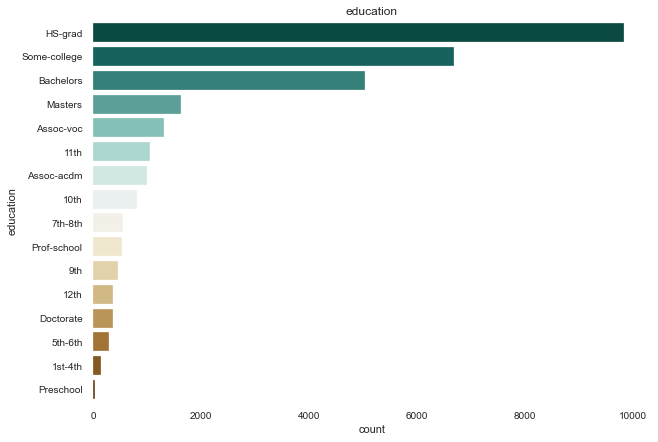

In [9]:
# education
countplot('education')

Married-civ-spouse       0.47
Never-married            0.32
Divorced                 0.14
Separated                0.03
Widowed                  0.03
Married-spouse-absent    0.01
Married-AF-spouse        0.00
Name: maritalstatus, dtype: float64


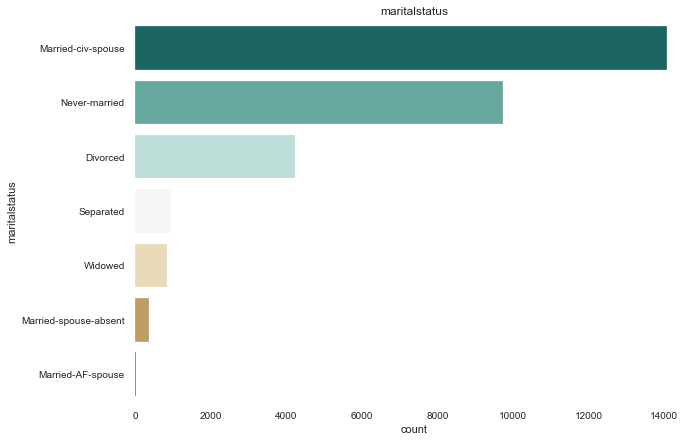

In [10]:
# maritalstatus
countplot('maritalstatus')

Prof-specialty       0.13
Craft-repair         0.13
Exec-managerial      0.13
Adm-clerical         0.12
Sales                0.12
Other-service        0.11
Machine-op-inspct    0.07
Transport-moving     0.05
Handlers-cleaners    0.04
Farming-fishing      0.03
Tech-support         0.03
Protective-serv      0.02
Priv-house-serv      0.00
Armed-Forces         0.00
Name: occupation, dtype: float64


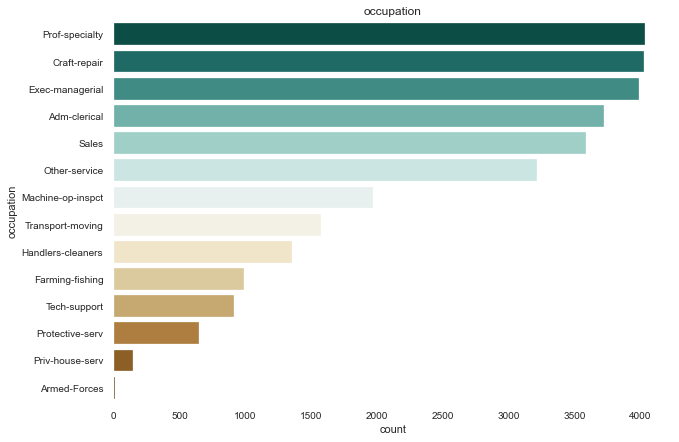

In [11]:
# occupation
data = data[data['occupation'] != '?']
countplot('occupation')

Husband           0.41
Not-in-family     0.26
Own-child         0.15
Unmarried         0.11
Wife              0.05
Other-relative    0.03
Name: relationship, dtype: float64


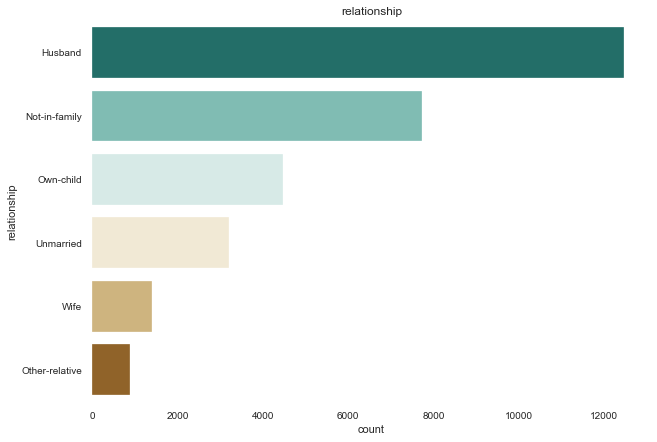

In [12]:
# relationship
data['relationship'] = np.where(data['relationship'] == '_wife_', 'Wife', data['relationship'])
data['relationship'] = np.where(data['relationship'] == '_husband_', 'Husband', data['relationship'])
countplot('relationship')

White                 0.86
Black                 0.09
Asian-Pac-Islander    0.03
Amer-Indian-Eskimo    0.01
Other                 0.01
Name: race, dtype: float64


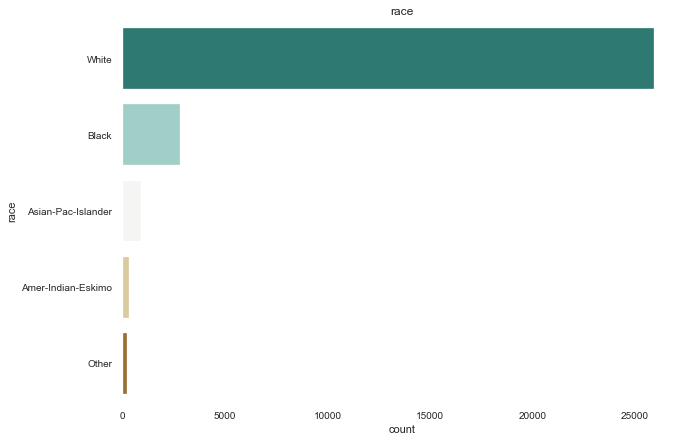

In [13]:
# race
countplot('race')

Male      0.68
Female    0.32
Name: sex, dtype: float64


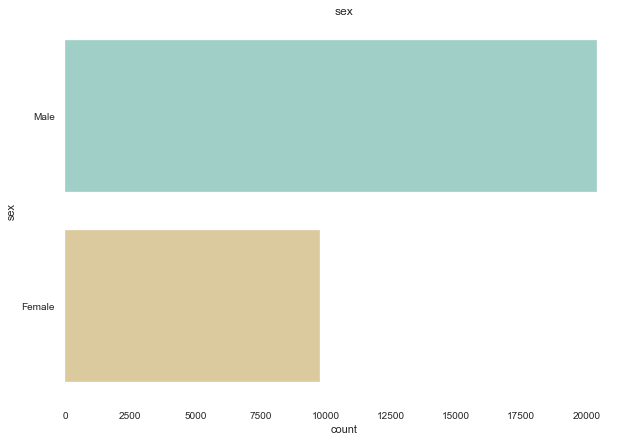

In [14]:
# sex
countplot('sex')

United-States    0.91
Other            0.06
Mexico           0.02
Philippines      0.01
Name: nativecountry, dtype: float64


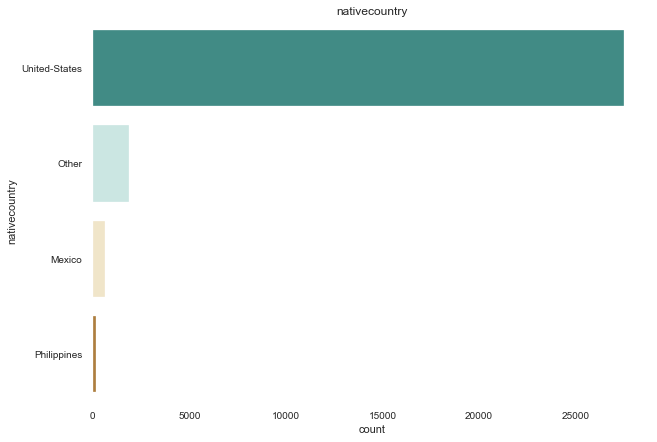

In [15]:
# nativecountry
data['nativecountry'] = np.where((data['nativecountry'] != 'United-States') & 
                                 (data['nativecountry'] != 'Mexico') &
                                 (data['nativecountry'] != 'Philippines'), 'Other', data['nativecountry'])
countplot('nativecountry')
# Agrupar o que for diferente de United-States e Mexico

<=50K    0.75
>50K     0.25
Name: over50k, dtype: float64


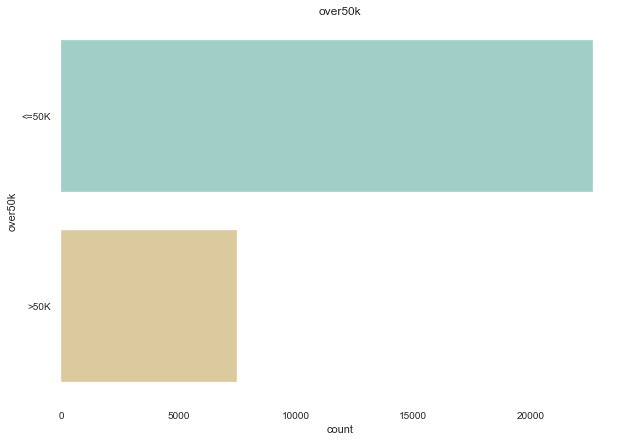

In [16]:
# over50k
countplot('over50k')

In [17]:
# Verifica o shape após a remoção das variáveis '?'
data.shape

(30162, 13)

## Variáveis Numéricas

count    30162.000000
mean        38.437902
std         13.134665
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64


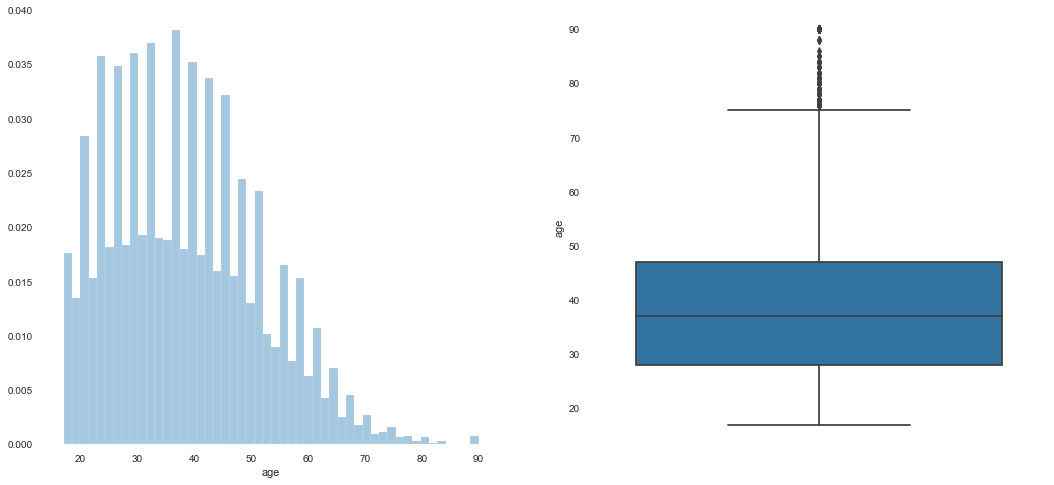

In [18]:
# Age
quantitativas('age')

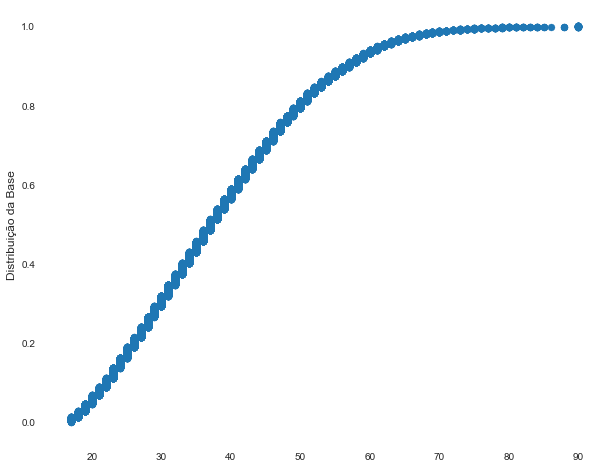

In [19]:
print_ecdf('age')

count    30162.000000
mean        40.931238
std         11.979984
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hoursperweek, dtype: float64


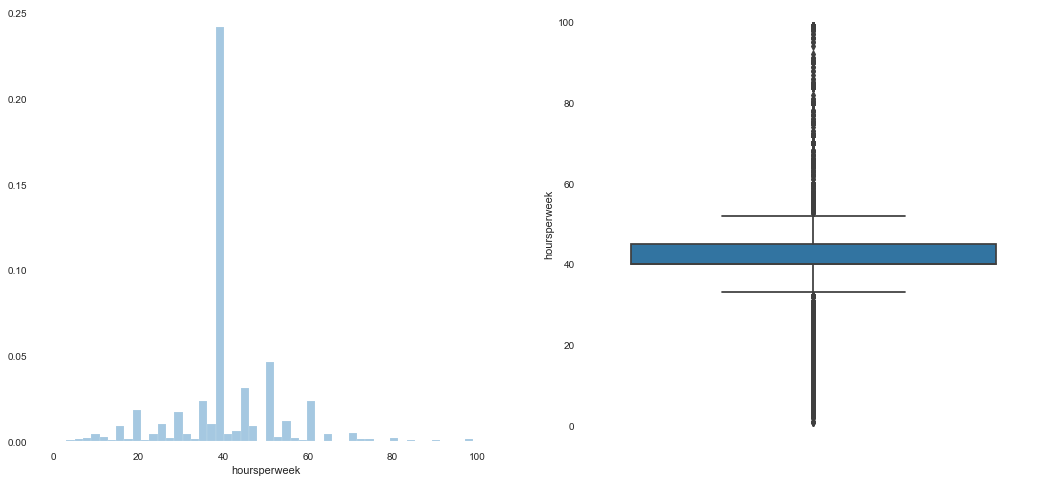

In [20]:
# hoursperweek
quantitativas('hoursperweek')
# Manter mesmo com outliers por entender que fazem parte do negócio

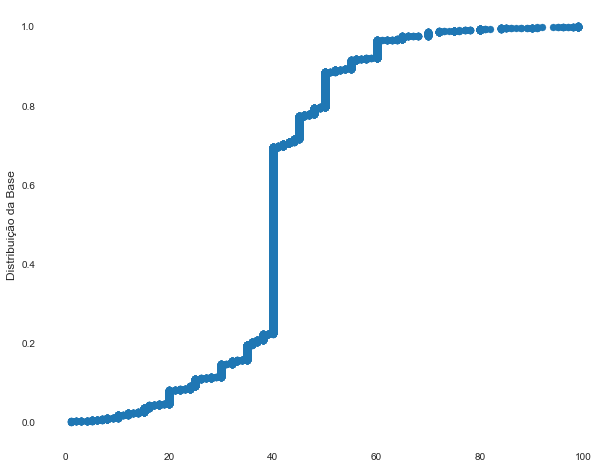

In [21]:
print_ecdf('hoursperweek')

In [22]:
# capitalgain
data['capitalgain'].describe()
# Remover

count    30162.000000
mean      1092.007858
std       7406.346497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capitalgain, dtype: float64

In [23]:
# capitalloss
data['capitalloss'].describe()
# Remover

count    30162.000000
mean        88.372489
std        404.298370
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capitalloss, dtype: float64

## Relação com Target

over50k         workclass     <=50K      >50K
3            Self-emp-inc  0.441341  0.558659
0             Federal-gov  0.612937  0.387063
1               Local-gov  0.705370  0.294630
4        Self-emp-not-inc  0.714286  0.285714
5               State-gov  0.731040  0.268960
2                 Private  0.781208  0.218792
6             Without-pay  1.000000  0.000000


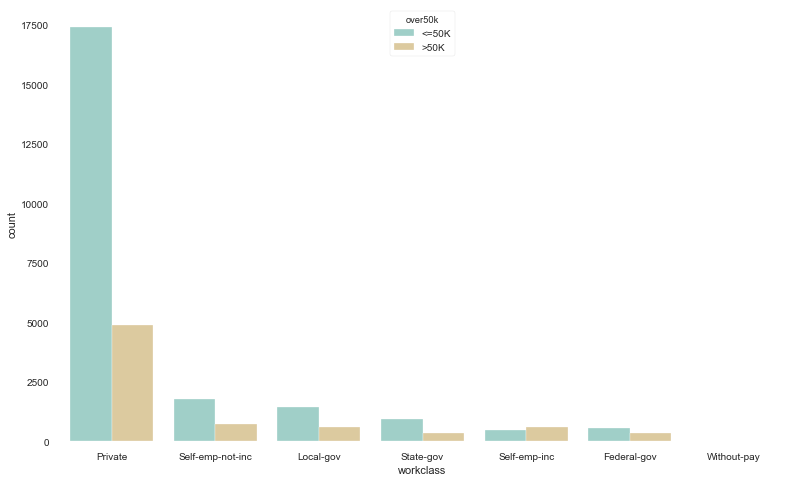

In [24]:
# workclass
relacao_target('workclass')

over50k     education     <=50K      >50K
14        Prof-school  0.250923  0.749077
10          Doctorate  0.253333  0.746667
12            Masters  0.435771  0.564229
9           Bachelors  0.578509  0.421491
8           Assoc-voc  0.736802  0.263198
7          Assoc-acdm  0.746032  0.253968
15       Some-college  0.799940  0.200060
11            HS-grad  0.835671  0.164329
2                12th  0.923077  0.076923
0                10th  0.928049  0.071951
5             7th-8th  0.937163  0.062837
1                11th  0.943702  0.056298
6                 9th  0.945055  0.054945
4             5th-6th  0.958333  0.041667
3             1st-4th  0.960265  0.039735
13          Preschool  1.000000  0.000000


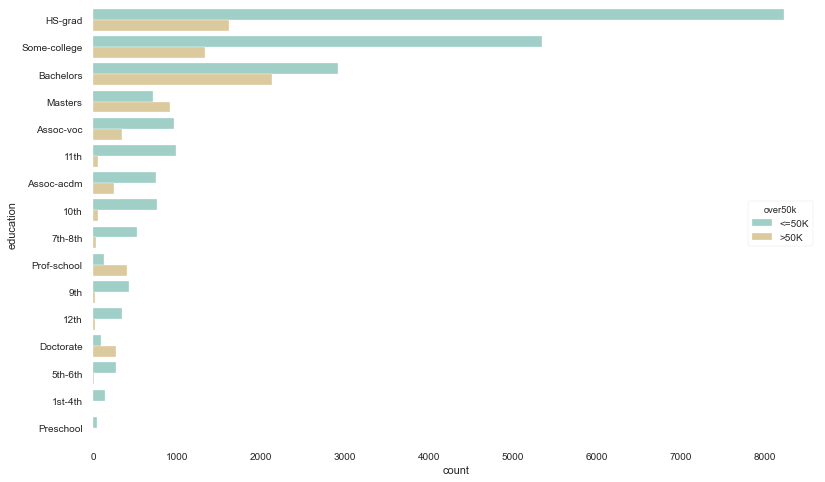

In [25]:
# education
print(pd.crosstab(data['education'], data['over50k'], normalize = 'index').reset_index().sort_values('>50K', ascending = False))
plt.figure(figsize = (13, 8))
sns.countplot(data = data, y = 'education', hue = 'over50k', order = data['education'].value_counts().index, palette = 'BrBG_r')

over50k          maritalstatus     <=50K      >50K
1            Married-AF-spouse  0.523810  0.476190
2           Married-civ-spouse  0.545041  0.454959
0                     Divorced  0.892738  0.107262
6                      Widowed  0.903265  0.096735
3        Married-spouse-absent  0.916216  0.083784
5                    Separated  0.929712  0.070288
4                Never-married  0.951676  0.048324


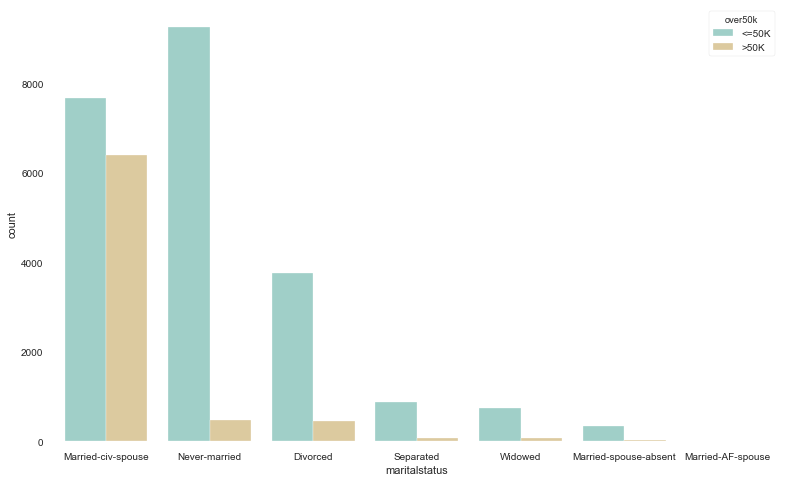

In [26]:
# maritalstatus
relacao_target('maritalstatus')

over50k         occupation     <=50K      >50K
3          Exec-managerial  0.514780  0.485220
9           Prof-specialty  0.551511  0.448489
10         Protective-serv  0.673913  0.326087
12            Tech-support  0.695175  0.304825
11                   Sales  0.729353  0.270647
2             Craft-repair  0.774690  0.225310
13        Transport-moving  0.797074  0.202926
0             Adm-clerical  0.866165  0.133835
6        Machine-op-inspct  0.875381  0.124619
4          Farming-fishing  0.883721  0.116279
1             Armed-Forces  0.888889  0.111111
5        Handlers-cleaners  0.938519  0.061481
7            Other-service  0.958904  0.041096
8          Priv-house-serv  0.993007  0.006993


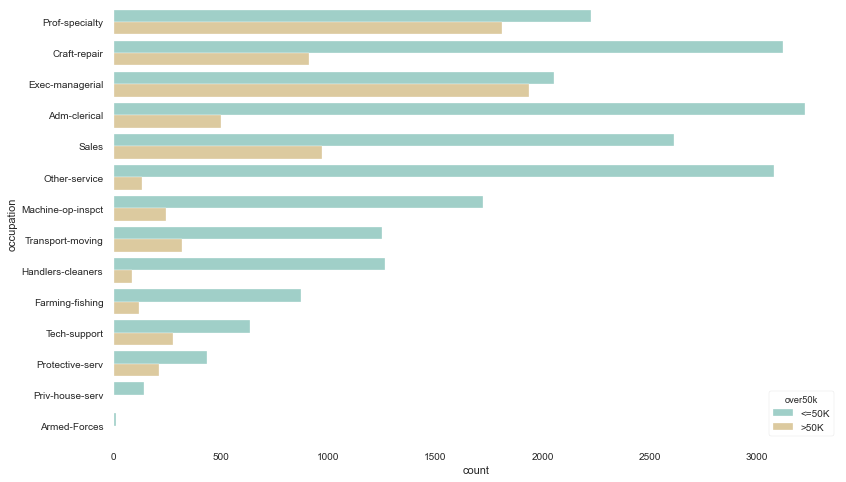

In [27]:
# occupation
print(pd.crosstab(data['occupation'], data['over50k'], normalize = 'index').reset_index().sort_values('>50K', ascending = False))
plt.figure(figsize = (13, 8))
sns.countplot(data = data, y = 'occupation', hue = 'over50k', order = data['occupation'].value_counts().index, palette = 'BrBG_r')

over50k    relationship     <=50K      >50K
5                  Wife  0.506401  0.493599
0               Husband  0.544331  0.455669
1         Not-in-family  0.893477  0.106523
4             Unmarried  0.933686  0.066314
2        Other-relative  0.960630  0.039370
3             Own-child  0.985670  0.014330


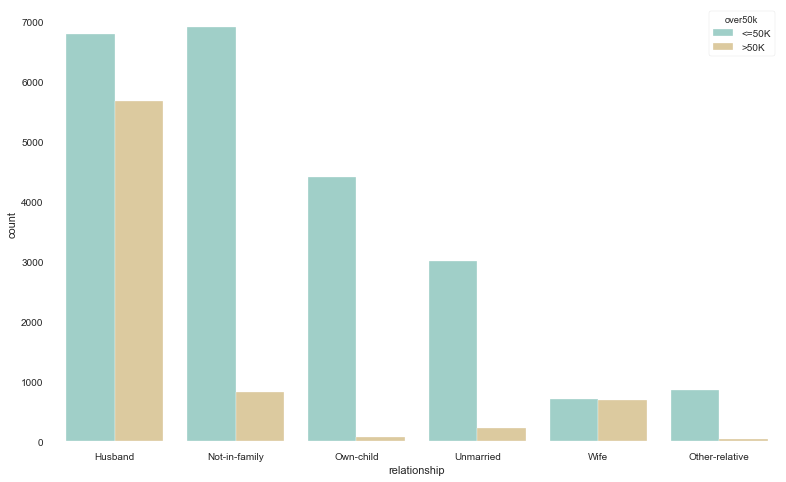

In [28]:
# relationship
relacao_target('relationship')

over50k                race     <=50K      >50K
1        Asian-Pac-Islander  0.722905  0.277095
4                     White  0.736282  0.263718
2                     Black  0.870075  0.129925
0        Amer-Indian-Eskimo  0.881119  0.118881
3                     Other  0.909091  0.090909


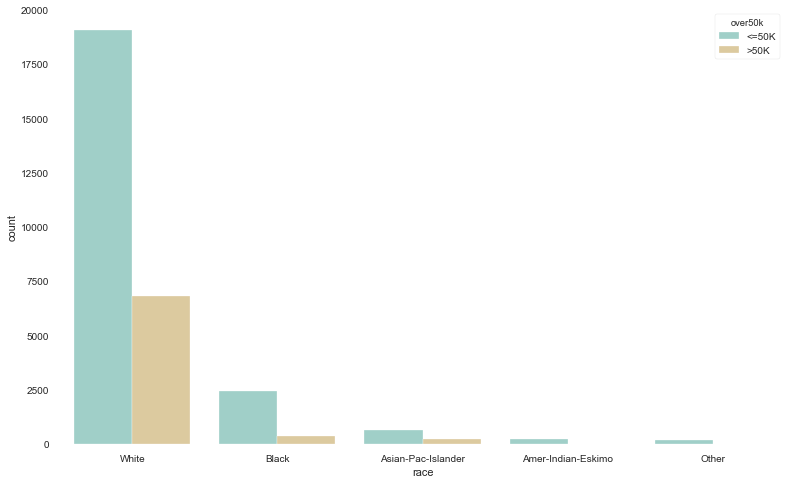

In [29]:
# sex
relacao_target('race')

over50k     sex     <=50K      >50K
1          Male  0.686163  0.313837
0        Female  0.886322  0.113678


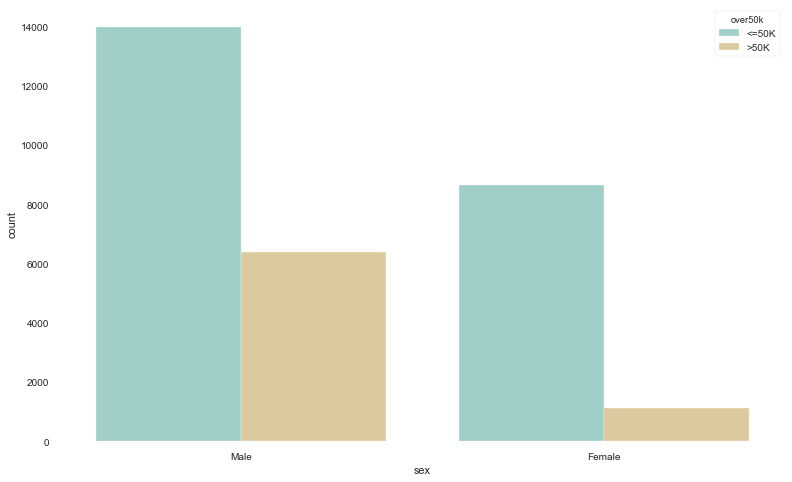

In [30]:
# sex
relacao_target('sex')

over50k  nativecountry     <=50K      >50K
2          Philippines  0.680851  0.319149
3        United-States  0.745673  0.254327
1                Other  0.774194  0.225806
0               Mexico  0.945902  0.054098


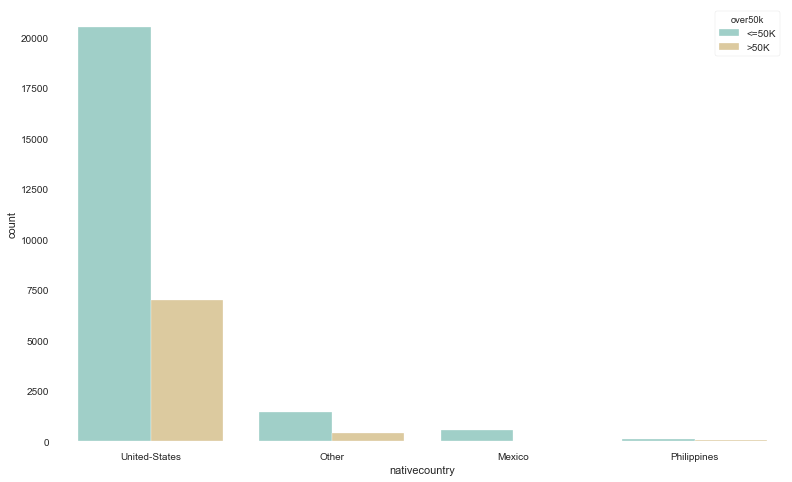

In [31]:
# nativecountry
relacao_target('nativecountry')

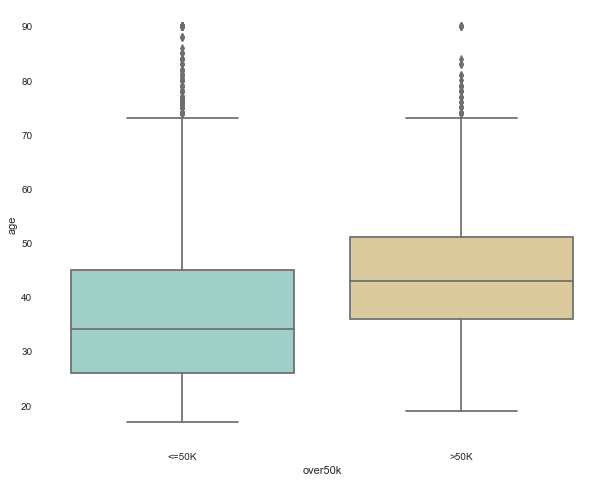

In [32]:
# age
plt.figure(figsize = (10, 8))
sns.boxplot(data = data, x = 'over50k', y = 'age', palette = 'BrBG_r')

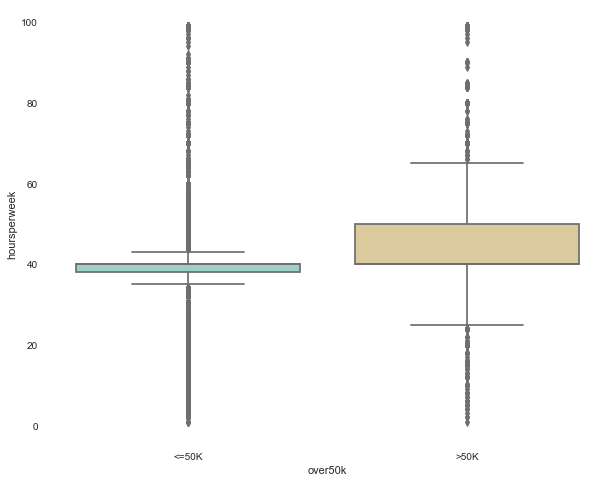

In [33]:
# hoursperweek

plt.figure(figsize = (10, 8))
sns.boxplot(data = data, x = 'over50k', y = 'hoursperweek', palette = 'BrBG_r')

# Separação da Base

In [34]:
# Iremos deletar as variáveis 'capitalgain' e 'capitalloss' pois mais de 90% está vazia, além da relationship por entender que a mesma possui a mesma informação da maritalstatus
del data['capitalgain']
del data['capitalloss']
del data['relationship']

In [35]:
# Separa as variáveis preditoras e target
x = data.iloc[:, 0:8]
y = data.iloc[:, 9]

# Binariza o target
y = np.where(y == '>50K', 1, 0)

In [36]:
# Transforma as variáveis preditoras em dummy
x = pd.get_dummies(x)
x.sample(3)

,age,hoursperweek,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
31751,31,38,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
30202,27,40,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
29495,27,40,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [37]:
# Separação em train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1)

# RFE para seleção de variáveis

Feature Ranking For Non-Discretised: [ 1  1  1  1  1  1  1  1 16  3  1  8 13 10  1  5  1  1  1  1  1  1 15  1
  1  1 12  1  9  1  4  6  1 17  1  1  1  2  1  1 14  1  1  1  1  1  7  1
  1 11  1  1  1]
Optimal number of features : 37


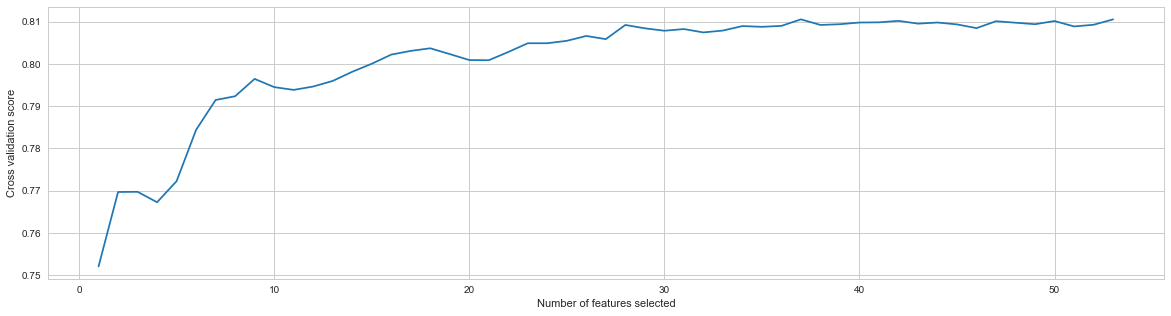

In [38]:
# Calcular o RFE para o conjunto de dados e representar graficamente a importância de cada recurso
selector1 = RFECV(RandomForestClassifier(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(x_train, y_train)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)

# Plot number of features VS. cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_);

In [39]:
testa = pd.DataFrame(x_train.columns[0:60]).reset_index()
testa2 = pd.DataFrame(selector1.ranking_).reset_index()
features = pd.merge(testa, testa2, on = 'index', how = 'left').rename(columns = {'0_x': 'Feature', 
                                                                                 '0_y': 'Ranking'})

features = features[features['Ranking'] == 1]
features = features['Feature'].tolist()

In [40]:
# Separa o treino utilizando apenas as variáveis selecionadas
x_train = x_train[features]
x_test = x_test[features]

# Modelagem Preditiva

Algoritmos que serão testados:

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

In [41]:
# Calcula o fpr e tpr para todos thresholds da classificação
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [42]:
# Função que roda cada algoritmo e retorna sua acuracia
def fit_ml_algo(algo, x_train, y_train, x_test, cv):
    # One Pass
    model = algo.fit(x_train, y_train)
    test_pred = model.predict(x_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(x_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(x_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  x_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

## Regressão Logistica

In [43]:
# Seleção de Hyperparametros da Regressão Logística

# Função que retorna o score base
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Especifica os parâmetros
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs = -1, 
                                   param_distributions = param_dist, 
                                   n_iter = n_iter_search,
                                   scoring = 'roc_auc')

start = time.time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 8.54 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.875 (std: 0.008)
Parameters: {'penalty': 'l2', 'intercept_scaling': 0.22383860651516438, 'class_weight': 'balanced', 'C': 165737942141743.47}

Model with rank: 2
Mean validation score: 0.875 (std: 0.008)
Parameters: {'penalty': 'l2', 'intercept_scaling': 6.667797443825851e+19, 'class_weight': None, 'C': 86914834870.83714}

Model with rank: 3
Mean validation score: 0.875 (std: 0.007)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2240.44885098676, 'class_weight': None, 'C': 5.2926401524640744e+16}

Model with rank: 4
Mean validation score: 0.873 (std: 0.008)
Parameters: {'penalty': 'l2', 'intercept_scaling': 0.0009071848096673421, 'class_weight': None, 'C': 78431.30639981761}

Model with rank: 5
Mean validation score: 0.855 (std: 0.005)
Parameters: {'penalty': 'l2', 'intercept_scaling': 3.024461529920339e-14, 'class_weight': None, 'C': 0.0017287164807774954}



In [44]:
# Regressão Logística
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 x_train, 
                                                                 y_train, 
                                                                 x_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("ACC: %s" % acc_log)
print("ACC CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

ACC: 83.36
ACC CV 10-Fold: 82.53
Running Time: 0:00:05.111752


In [45]:
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      5642
           1       0.72      0.55      0.63      1899

    accuracy                           0.83      7541
   macro avg       0.79      0.74      0.76      7541
weighted avg       0.83      0.83      0.83      7541



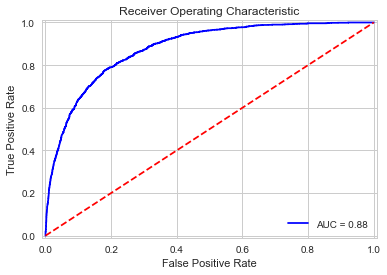

In [46]:
plot_roc_curve(y_test, probs_log)

# KNN

In [47]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 x_train, 
                                                                                                 y_train, 
                                                                                                 x_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 78.56
Accuracy CV 10-Fold: 78.66
Running Time: 0:00:04.114919


In [48]:
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      5642
           1       0.58      0.55      0.56      1899

    accuracy                           0.79      7541
   macro avg       0.71      0.71      0.71      7541
weighted avg       0.78      0.79      0.78      7541



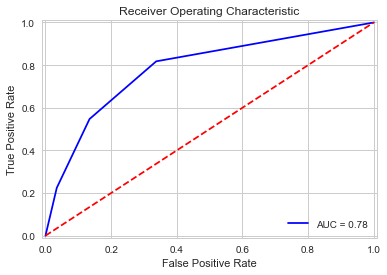

In [49]:
plot_roc_curve(y_test, probs_knn)

## Gaussian Naive Bayes

In [50]:
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     x_train, 
                                                                                     y_train, 
                                                                                     x_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 77.09
Accuracy CV 10-Fold: 77.05
Running Time: 0:00:00.370999


In [51]:
print(metrics.classification_report(y_test, test_pred_gaussian))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      5642
           1       0.53      0.74      0.62      1899

    accuracy                           0.77      7541
   macro avg       0.72      0.76      0.73      7541
weighted avg       0.81      0.77      0.78      7541



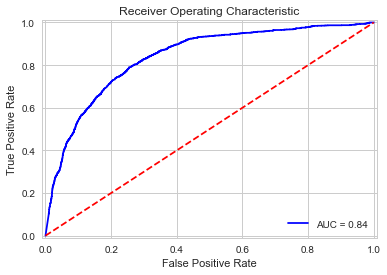

In [52]:
plot_roc_curve(y_test, probs_gau)

## Linear SVC

In [53]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           x_train, 
                                                                                           y_train,
                                                                                           x_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 76.69
Accuracy CV 10-Fold: 79.62
Running Time: 0:00:11.211000


In [54]:
print(metrics.classification_report(y_test, test_pred_svc))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      5642
           1       0.91      0.08      0.15      1899

    accuracy                           0.77      7541
   macro avg       0.84      0.54      0.51      7541
weighted avg       0.80      0.77      0.69      7541



## Stochastic Gradient Descent

In [55]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 x_train, 
                                                                 y_train, 
                                                                 x_test, 
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 80.86
Accuracy CV 10-Fold: 77.8
Running Time: 0:00:04.436980


In [56]:
print(metrics.classification_report(y_test, test_pred_sgd))

              precision    recall  f1-score   support

           0       0.91      0.82      0.87      5642
           1       0.59      0.76      0.67      1899

    accuracy                           0.81      7541
   macro avg       0.75      0.79      0.77      7541
weighted avg       0.83      0.81      0.82      7541



## Decision Tree

In [57]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             x_train, 
                                                             y_train, 
                                                             x_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 77.91
Accuracy CV 10-Fold: 77.67
Running Time: 0:00:00.657948


In [58]:
print(metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5642
           1       0.57      0.53      0.55      1899

    accuracy                           0.78      7541
   macro avg       0.71      0.69      0.70      7541
weighted avg       0.77      0.78      0.78      7541



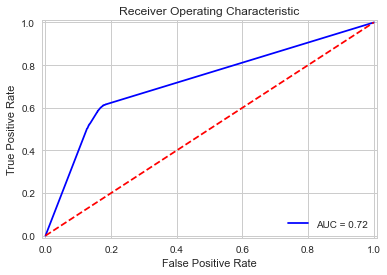

In [59]:
plot_roc_curve(y_test, probs_dt)

## Random Forest

In [60]:
# Random Forest Classifier - Random Search para Hyperparameters
# Função para calcular os scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Especifica os hyperparametros
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search,
                                   scoring = 'roc_auc')

start = time.time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3.41 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.884 (std: 0.006)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 6}

Model with rank: 2
Mean validation score: 0.882 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.881 (std: 0.006)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 13}

Model with rank: 4
Mean validation score: 0.880 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 9, 'min_samples_split': 3}

Model with rank: 5
Mean validation score: 0.880 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'entropy', '

In [64]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(bootstrap = False,
                             criterion = 'entropy',
                             max_depth = None,
                             max_features = 8,
                             min_samples_leaf = 10,
                             min_samples_split = 6)

train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             x_train, 
                                                             y_train, 
                                                             x_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds = rf_time))

Accuracy: 84.17
Accuracy CV 10-Fold: 83.32
Running Time: 0:00:11.195999


In [65]:
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      5642
           1       0.74      0.58      0.65      1899

    accuracy                           0.84      7541
   macro avg       0.80      0.75      0.77      7541
weighted avg       0.83      0.84      0.83      7541



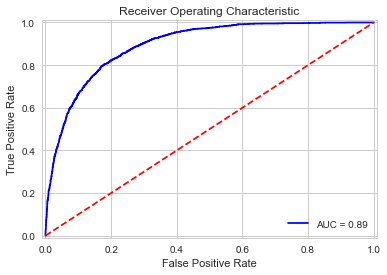

In [66]:
plot_roc_curve(y_test, probs_rf)

## Gradient Boosting

In [67]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 x_train, 
                                                                 y_train, 
                                                                 x_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 84.09
Accuracy CV 10-Fold: 83.36
Running Time: 0:00:08.597003


In [68]:
print(metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5642
           1       0.75      0.55      0.64      1899

    accuracy                           0.84      7541
   macro avg       0.81      0.75      0.77      7541
weighted avg       0.83      0.84      0.83      7541



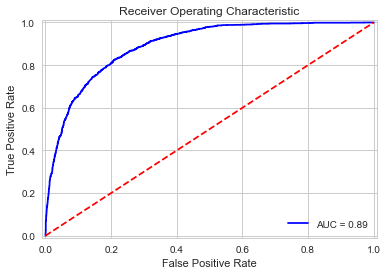

In [69]:
plot_roc_curve(y_test, probs_gbt)

# Ranking dos Resultados

In [91]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,84.17
7,Gradient Boosting Trees,84.09
1,Logistic Regression,83.36
4,Stochastic Gradient Decent,80.86
0,KNN,78.56
6,Decision Tree,77.91
3,Naive Bayes,77.09
5,Linear SVC,76.69


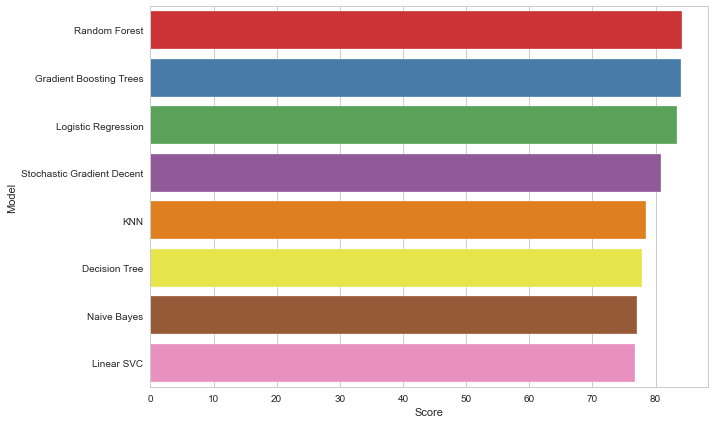

In [93]:
plt.figure(figsize = (10, 7))
sns.barplot(data = models.sort_values(by='Score', ascending=False), y = 'Model', x = 'Score', palette = 'Set1')

### Ranking com CV = 10

In [94]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting Trees,83.36
2,Random Forest,83.32
1,Logistic Regression,82.53
5,Linear SVC,79.62
0,KNN,78.66
4,Stochastic Gradient Decent,77.80
6,Decision Tree,77.67
3,Naive Bayes,77.05


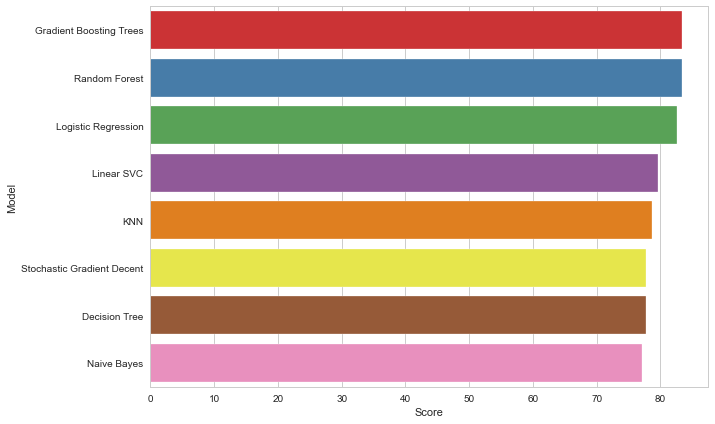

In [95]:
plt.figure(figsize = (10, 7))
sns.barplot(data = models.sort_values(by='Score', ascending=False), y = 'Model', x = 'Score', palette = 'Set1')

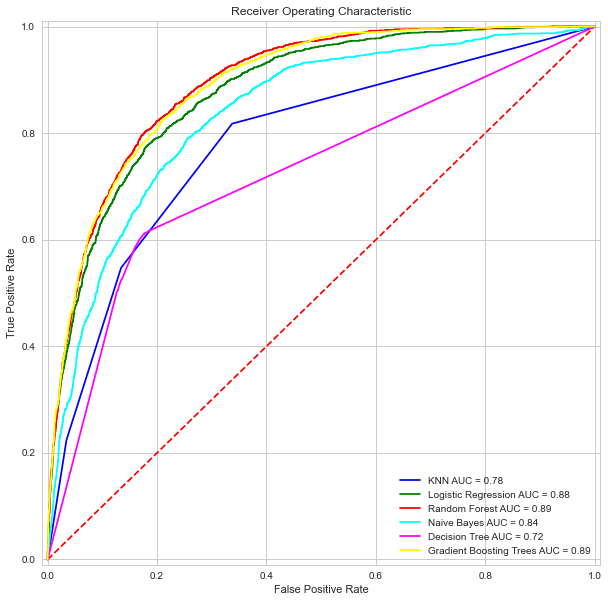

In [96]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()

# Feature Importance e SHAP

Por conta do Gradient Boosting liderar o ranking do CV, iremos utilizá-lo pois garante maior confiabilidade nos resultados.

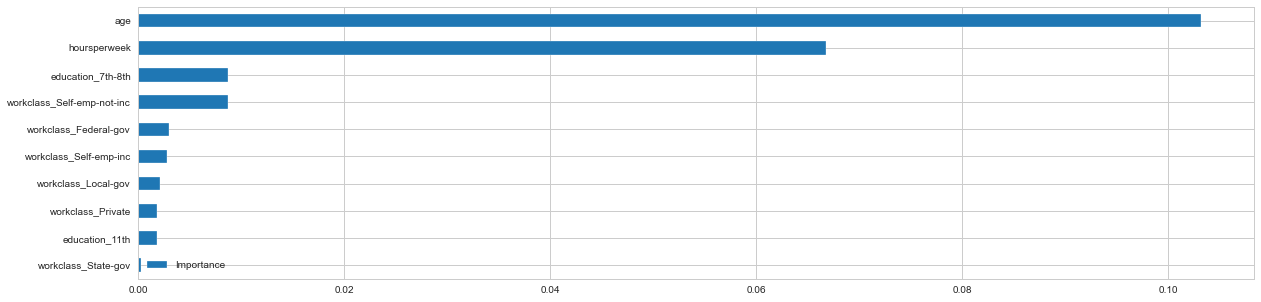

In [73]:
# Extração das features importances
clf = GradientBoostingClassifier()
clf.fit(x_train, y_train)

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index = x_train.columns, columns=["Importance"]).head(10)
importance.sort_values(by = 'Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

# Utilização do SHAP

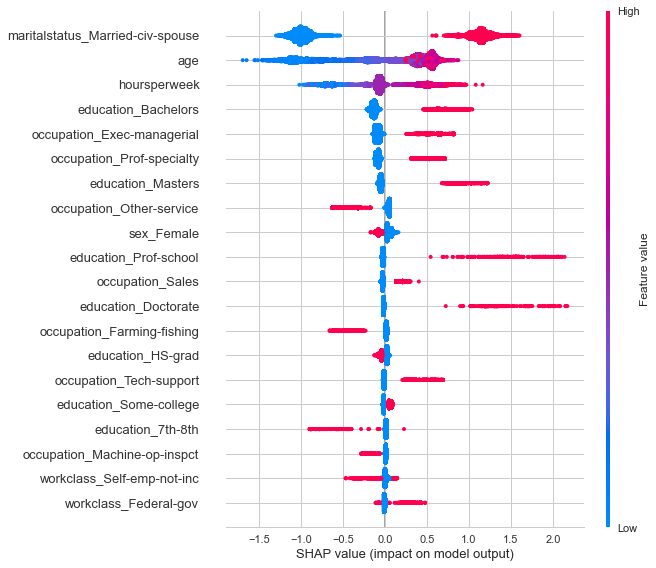

In [74]:
# Rotula a base
X = pd.DataFrame(x_train)
X.columns = x_train.columns

# Cria o explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

### Salvar o artefato do modelo

In [76]:
filename = 'RendaPrevista_GB_v2.sav'
pickle.dump(clf, open(filename, 'wb'))